## Importation des packages utilisés

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc 

## Implémentation d’un générateur de lois alpha-stables

### Objectif
Cette première étape consiste à implémenter un générateur permettant de simuler des variables aléatoires suivant une distribution alpha-stable 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
)
S(α,β,σ,μ), conformément à la description de l'Appendix B de l’article Sisson (2011). L'algorithme retenu est celui de Chambers, Mallows et Stuck (1976), qui repose sur la transformation de deux lois élémentaires.

### Générateur CMS : implémentation Python


In [3]:
def sample_alpha_stable(alpha, beta, gamma=1, delta=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return gamma * X + delta



### Validation empirique : visualisation de quelques lois

Nous testons le générateur pour différentes valeurs de \(\alpha\) et \(\beta\), en représentant les histogrammes des échantillons simulés.



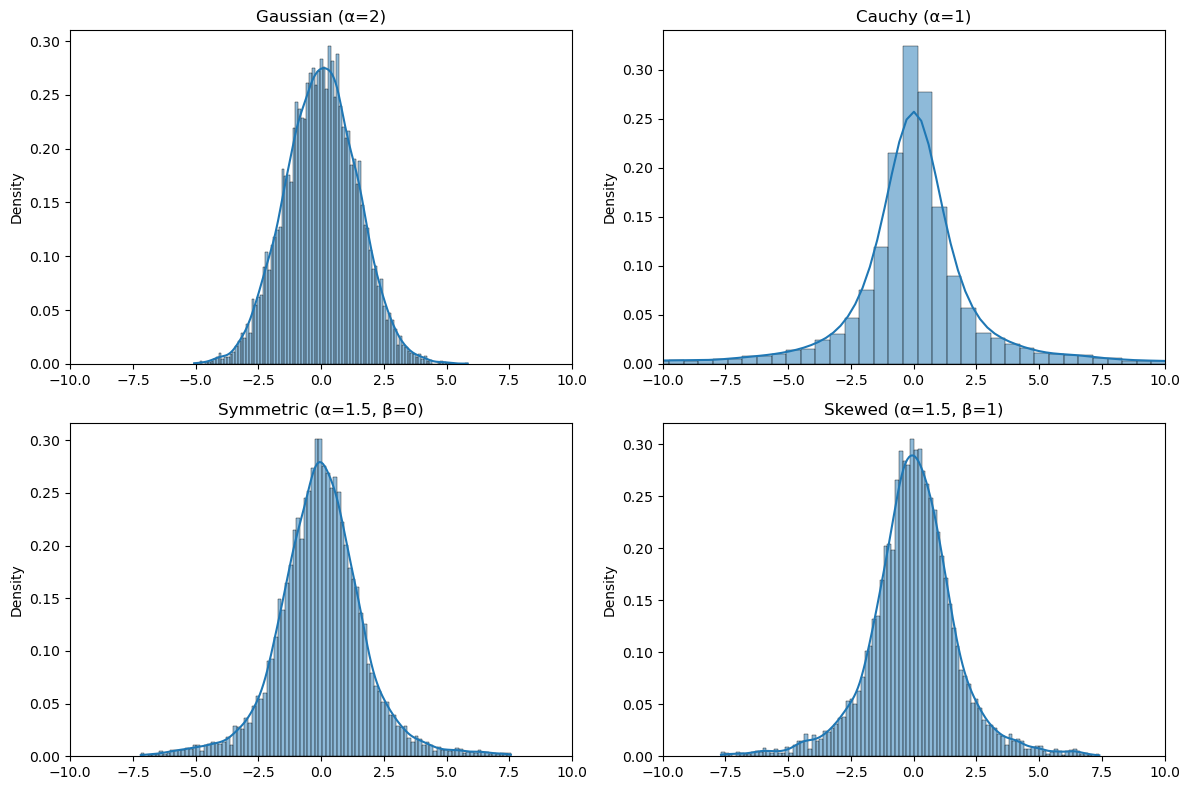

In [4]:

# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, gamma, delta, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, gamma, delta, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


### Validation via la fonction caractéristique

Une seconde manière de tester la validité du générateur consiste à comparer la **fonction caractéristique empirique** 


La densité des lois alpha-stables n'étant généralement pas disponible en forme fermée (sauf cas particuliers), on ne peut pas la comparer directement à une estimation empirique. En revanche, leur **fonction caractéristique** (FC) est connue explicitement et constitue un outil efficace pour valider numériquement un générateur de variables alpha-stables.

#### Définition

La fonction caractéristique d’une variable aléatoire \( X \) est définie par :

$$
\varphi_X(t) = \mathbb{E}[e^{itX}]
$$

Pour \( X \sim \mathcal{S}(\alpha, \beta, \gamma, \delta) \), la fonction caractéristique théorique est :

- Si \( \alpha =/ 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma^\alpha |t|^\alpha \left[ 1 - i\beta\, \text{sign}(t) \tan\left( \frac{\pi \alpha}{2} \right) \right] + i \delta t \right)
$$

- Si \( \alpha = 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma |t| \left[ 1 + i\beta \frac{2}{\pi} \, \text{sign}(t) \log|t| \right] + i \delta t \right)
$$

#### Méthode

On génère un grand nombre d’observations \( X_1, \dots, X_N \) avec le générateur, puis on calcule l’estimateur empirique :

$$
\hat{\varphi}_X(t) = \frac{1}{N} \sum_{j=1}^{N} e^{itX_j}
$$

On compare ensuite les resultats obtenus via les courbes :


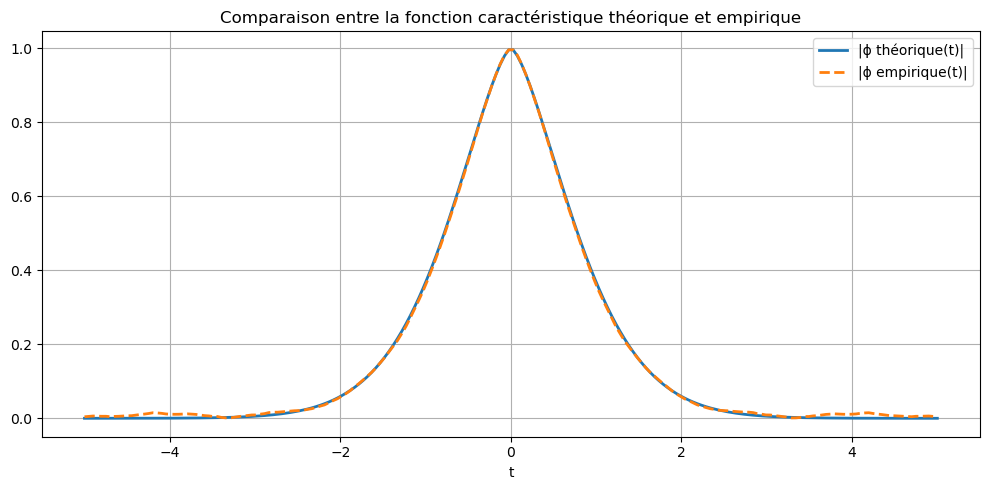

In [5]:
# Fonction caractéristique théorique
def theoretical_cf(t, alpha, beta, gamma=1, delta=0):
    if alpha != 1:
        return np.exp(
            -gamma**alpha * np.abs(t)**alpha *
            (1 - 1j * beta * np.sign(t) * np.tan(np.pi * alpha / 2)) +
            1j * delta * t
        )
    else:
        return np.exp(
            -gamma * np.abs(t) *
            (1 + 1j * beta * (2 / np.pi) * np.sign(t) * np.log(np.abs(t))) +
            1j * delta * t
        )

# Estimateur empirique de la fonction caractéristique
def empirical_cf(t_vals, samples):
    return np.array([np.mean(np.exp(1j * t * samples)) for t in t_vals])

# Paramètres de test
alpha = 1.5
beta = 0
gamma = 1
delta = 0
N = 10_000

# Génération d'échantillons
samples = sample_alpha_stable(alpha, beta, gamma, delta, size=N)

# Grille de t
t_vals = np.linspace(-5, 5, 200)

# Fonction caractéristique théorique et empirique
phi_theo = theoretical_cf(t_vals, alpha, beta, gamma, delta)
phi_emp = empirical_cf(t_vals, samples)

# Tracé des modules
plt.figure(figsize=(10, 5))
plt.plot(t_vals, np.abs(phi_theo), label="|ϕ théorique(t)|", lw=2)
plt.plot(t_vals, np.abs(phi_emp), label="|ϕ empirique(t)|", lw=2, linestyle="--")
plt.xlabel("t")
plt.title("Comparaison entre la fonction caractéristique théorique et empirique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Intégration de RQMC pour la simulation de lois alpha-stables

Dans cette partie, nous allons adapter notre générateur alpha-stable en utilisant des **points RQMC (Randomized Quasi-Monte Carlo)**. Nous allons comparer par la suite les résultats obtenus par RQMC avec ceux de Monte Carlo standard.

Les générateurs RQMC, comme **Sobol**, sont conçus pour répartir les points d’échantillonnage de manière plus uniforme dans l’espace, ce qui permet de mieux couvrir l’ensemble de l’intervalle d’intégration avec moins de points, tout en conservant des propriétés statistiques intéressantes. Cela se traduit par une estimation plus précise des intégrales, ce qui est particulièrement utile dans le cadre des simulations de distributions alpha-stables.

L’idée ici est de **générer les points uniformes** nécessaires pour transformer ensuite ces points en variables suivant une **loi uniforme** sur l'intervalle `(-π/2, π/2)` et une **loi exponentielle**.

- **Loi uniforme** : Cela est assez simple à réaliser en utilisant directement les points générés par RQMC, qui sont uniformément distribués dans l'intervalle `[0, 1]`. En les transformant de manière appropriée, on obtient les points uniformément distribués sur `(-π/2, π/2)`.

- **Loi exponentielle** : Pour la génération de la loi exponentielle, nous avons utilisé le **théorème de l'inversion**. En partant du fait que si `U ~ Uniform(0, 1)`, la transformation inverse `W = -log(1 - U)` permet d’obtenir une variable suivant une loi exponentielle de paramètre `λ = 1`.

In [6]:
# Générateur RQMC
def generate_rqmc_points(n_samples, dim):
    """
    Génère des points RQMC (par exemple, avec la suite de Sobol) dans un espace [0, 1].
    """
    sampler = qmc.Sobol(d=dim, scramble=True)
    points = sampler.random(n_samples)
    return points
#Fonction ci-dessous à revoir : utilisation de rqmc dans exponenetielle aussi
def sample_alpha_stable_with_rqmc_test(alpha, beta, gamma=1, delta=0, size=1):
    """
    Génère des échantillons alpha-stables à l'aide de RQMC pour générer des points uniformes et exponentiels.
    """
    # Utilisation de RQMC pour générer des points
    rqmc_points = generate_rqmc_points(size, 1) 
    
    # Transformation pour obtenir la loi uniforme U sur (-pi/2, pi/2)
    U = np.pi * (rqmc_points - 0.5) 
    
    # Transformation inverse pour obtenir W suivant une loi exponentielle
    W = -np.log(1 - rqmc_points)  # D'après théorème de l'inversion

    # Calcul de l'échantillon alpha-stable
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = (np.cos((1 - alpha) * U)) / W
        X = numerator / denominator * (inner ** ((1 - alpha) / alpha))
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * W * np.cos(U)) / ((np.pi / 2) + beta * U)
        X = B

    # Retourner l'échantillon alpha-stable final avec les paramètres gamma et delta
    return gamma * X + delta

In [7]:
def sample_alpha_stable_with_rqmc(alpha, beta, gamma=1, delta=0, size=1):
    """
    Génère des échantillons alpha-stables à l'aide de RQMC pour générer des points uniformes et exponentiels.
    """
    # Utilisation de RQMC pour générer des points
    rqmc_points = generate_rqmc_points(size, 1) 
    
    # Transformation pour obtenir la loi uniforme U sur (-pi/2, pi/2)
    U = np.pi * (rqmc_points - 0.5) 
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    
    # Calcul de l'échantillon alpha-stable
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = (np.cos((1 - alpha) * U)) / W
        X = numerator / denominator * (inner ** ((1 - alpha) / alpha))
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * W * np.cos(U)) / ((np.pi / 2) + beta * U)
        X = B

    # Retourner l'échantillon alpha-stable final avec les paramètres gamma et delta
    return gamma * X + delta

c:\Users\ibrah\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
c:\Users\ibrah\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
c:\Users\ibrah\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
c:\Users\ibrah\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


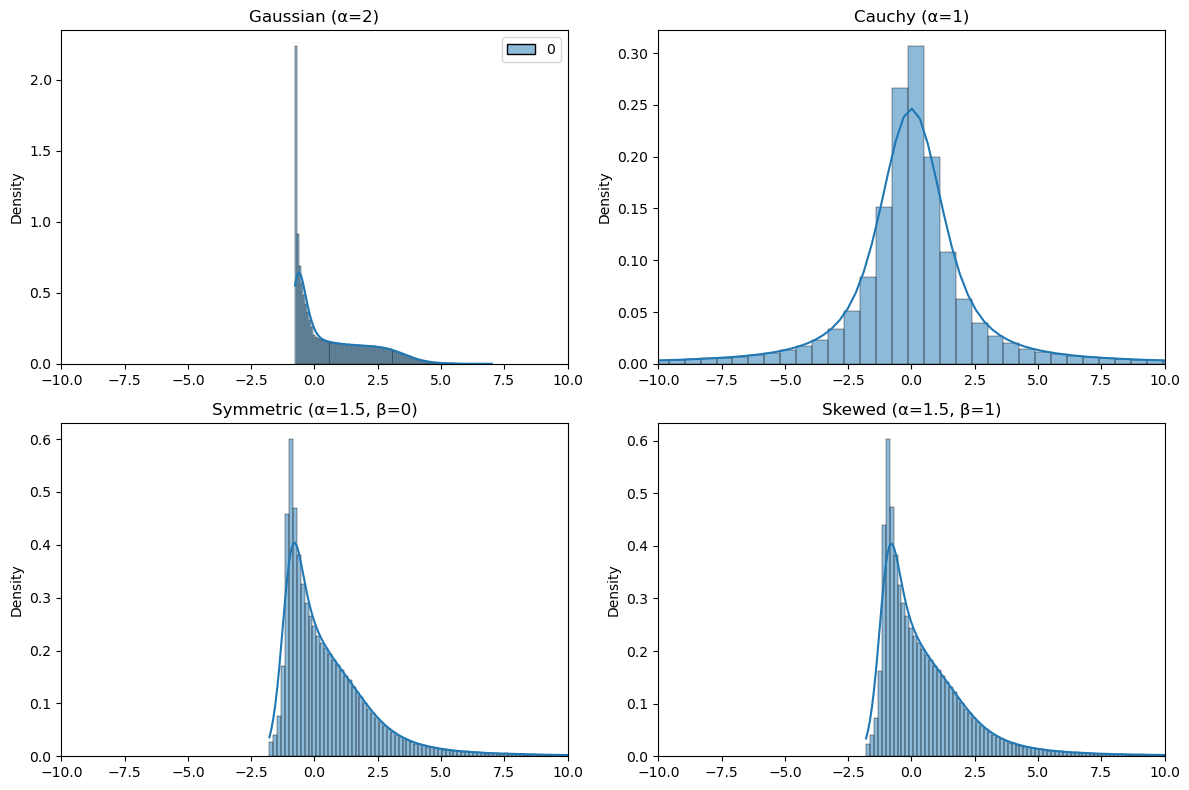

In [8]:
# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, gamma, delta, title) in enumerate(params):
    data = sample_alpha_stable_with_rqmc_test(alpha, beta, gamma, delta, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

c:\Users\ibrah\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


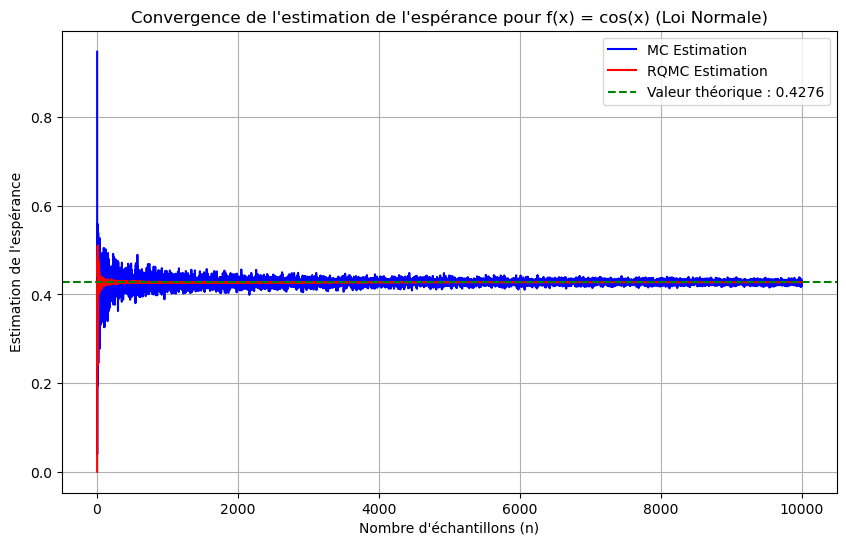

MSE Monte Carlo : 0.000164173327158323
MSE RQMC : 2.6203785302150297e-05


In [ ]:
# Fonction à évaluer 
def f(x):
    return np.exp(-x**2)

# Paramètres de la loi normale
mu = 0  # Moyenne
sigma = 1  # Ecart-type
max_samples = 10000  # Nombre maximum d'échantillons

# Variables pour stocker les résultats
mc_estimations = []
rqmc_estimations = []
#loi cauchy
delta = 0  
gamma = 1  
alpha = 1 
beta = 0
# Valeur théorique à retrouver
theoretical_expectation = 0.4275835762
for n in range(1, max_samples + 1):
    # Estimation MC
    samples_mc = sample_alpha_stable(alpha, beta, gamma, delta, n)
    mc_estimations.append(np.mean(f(samples_mc)))
    
    # Estimation RQMC
    samples_rqmc = sample_alpha_stable_with_rqmc_test(alpha, beta, gamma, delta, n)
    rqmc_estimations.append(np.mean(f(samples_rqmc)))
# Plot des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_samples + 1), mc_estimations, label="MC Estimation", color='blue')
plt.plot(range(1, max_samples + 1), rqmc_estimations, label="RQMC Estimation", color='red')

plt.axhline(y=theoretical_expectation, color='green', linestyle='--', label=f"Valeur théorique : {theoretical_expectation:.4f}")

plt.title("Convergence de l'estimation de l'espérance pour f(x) = cos(x) (Loi Normale)")
plt.xlabel("Nombre d'échantillons (n)")
plt.ylabel("Estimation de l'espérance")
plt.legend()
plt.grid(True)
plt.show()

# Calcul de l'erreur quadratique moyenne (MSE) par rapport à la valeur théorique
mse_mc = np.mean((np.array(mc_estimations) - theoretical_expectation)**2)
mse_rqmc = np.mean((np.array(rqmc_estimations) - theoretical_expectation)**2)

print(f"MSE Monte Carlo : {mse_mc}")
print(f"MSE RQMC : {mse_rqmc}")

In [10]:
n_samples = 2**12 # Fixer le nombre d'échantillons
n_repeats = 500    # Nombre de répétitions pour chaque méthode
mc_estimations = []
rqmc_estimations = []
delta = 0  
gamma = 1  
alpha = 1 
beta = 0

# Répéter les simulations et stocker les résultats dans des tableaux
for i in range(n_repeats):
    samples_mc = sample_alpha_stable(alpha, beta, gamma, delta, n_samples)
    mc_estimations.append(np.mean(f(samples_mc)))
    
    # Estimation RQMC
    samples_rqmc = sample_alpha_stable_with_rqmc_test(alpha, beta, gamma, delta, n_samples)
    rqmc_estimations.append(np.mean(f(samples_rqmc)))
    
var_mc= np.var(mc_estimations)
var_rqmc= np.var(rqmc_estimations)
print("La variance de MC standard est", var_mc,"\n La variance de RQMC est", var_rqmc)

La variance de MC standard est 3.8888235515581224e-05 
 La variance de RQMC est 9.613015790208026e-13


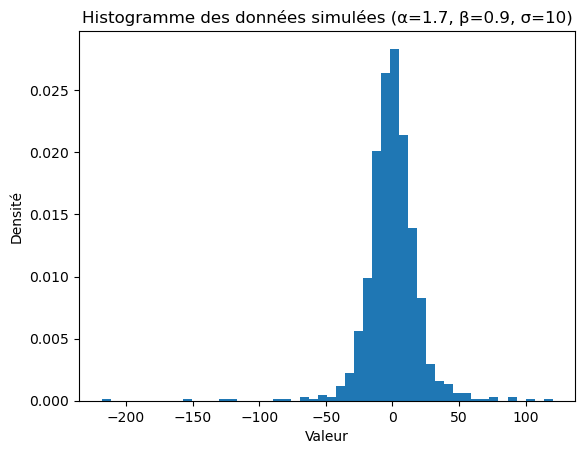

In [11]:
alpha = 1.7
beta = 0.9
gamma = 10
delta = 0
size = 1000  # Nombre d'observations 

# Simuler les données
data = sample_alpha_stable(alpha, beta, gamma, delta, size)
# Afficher un histogramme des données simulées
plt.hist(data, bins=50, density=True)
plt.title(f"Histogramme des données simulées (α={alpha}, β={beta}, σ={gamma})")
plt.xlabel("Valeur")
plt.ylabel("Densité")
plt.show()

In [12]:
# Calculer les quantiles des données simulées
quantiles_data = np.percentile(data, [5, 25, 50, 75, 95])

# Afficher les quantiles
print(f"Quantiles des données simulées (5%, 25%, 50%, 75%, 95%) : {quantiles_data}")

# Estimations basées sur les quantiles
v_alpha = (quantiles_data[3] - quantiles_data[1]) / (quantiles_data[2] - quantiles_data[0])  # Exemple de calcul pour v_alpha
v_beta = (quantiles_data[4] - quantiles_data[0]) / (quantiles_data[2] - quantiles_data[1])  # Exemple pour v_beta
v_gamma = (quantiles_data[3] - quantiles_data[1]) / gamma

# Afficher les estimations des paramètres
print(f"Estimation de alpha (v_alpha) : {v_alpha}")
print(f"Estimation de beta (v_beta) : {v_beta}")
print(f"Estimation de gamma (v_gamma) : {v_gamma}")


Quantiles des données simulées (5%, 25%, 50%, 75%, 95%) : [-25.61442365  -9.5782727   -0.23058072  10.0619285   26.48720714]
Estimation de alpha (v_alpha) : 0.7737284401656216
Estimation de beta (v_beta) : 5.573742790718544
Estimation de gamma (v_gamma) : 1.964020120119045


In [13]:
# Paramètres pour la simulation
alpha = 1.7  # Paramètre alpha pour la simulation
beta = 0.9   # Paramètre beta pour la simulation
gamma = 10   # Paramètre gamma pour la simulation
mu = 0       # Paramètre mu pour la simulation
size = 1000  # Nombre de données simulées
epsilon = 0.1  # Seuil de tolérance (distance acceptée entre les quantiles)
num_samples = 1000  # Nombre de simulations à effectuer

# Fonction pour calculer les quantiles
def compute_quantiles(data):
    return np.percentile(data, [5, 25, 50, 75, 95])

# Fonction pour générer des données alpha-stables
def sample_alpha_stable(alpha, beta, gamma, mu, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exponentielle
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) * W
        X = numerator / denominator * (inner)**((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * np.cos(U) / ((np.pi / 2) + beta * U))
        X = B
    return gamma * X + mu

# Fonction ABC-Reject
def abc_reject(prior, num_samples, epsilon):
    accepted_params = []  # Liste pour stocker les paramètres acceptés
    
    for _ in range(num_samples):
        # 1. Simuler un paramètre de la prior (ici, une distribution uniforme)
        theta = prior()
        
        # 2. Simuler des données avec ce paramètre
        simulated_data = sample_alpha_stable(alpha=theta[0], beta=theta[1], gamma=theta[2], mu=mu, size=size)
        
        # 3. Calculer les quantiles des données simulées
        quantiles_simulated = compute_quantiles(simulated_data)
        
        # 4. Utiliser les quantiles simulés comme "données observées"
        quantiles_observed = compute_quantiles(data) # Ici, les données simulées servent de référence
        
        # 5. Calculer la distance entre les quantiles simulés et observés
        distance = np.linalg.norm(quantiles_simulated - quantiles_observed)
        
        # 6. Si la distance est inférieure au seuil, accepter ce paramètre
        if distance < epsilon:
            accepted_params.append(theta)
    
    return accepted_params

# Exemple de prior (ici, une distribution uniforme pour alpha, beta, gamma)
def prior():
    alpha_sample = np.random.uniform(1.5, 2)  # Prior sur alpha
    beta_sample = np.random.uniform(-1, 1)   # Prior sur beta
    gamma_sample = np.random.uniform(1, 20)  # Prior sur gamma
    return (alpha_sample, beta_sample, gamma_sample)

# Lancer l'algorithme ABC-Reject
accepted_parameters = abc_reject(prior, num_samples, epsilon)

# Afficher les résultats
print(f"Nombre de paramètres acceptés : {len(accepted_parameters)}")

# Optionnel : afficher quelques-uns des paramètres acceptés pour vérifier
print(f"Quelques paramètres acceptés : {accepted_parameters[:10]}")



Nombre de paramètres acceptés : 0
Quelques paramètres acceptés : []


# Question 3. 

The objective of the question is properly to implement the methods used in the Article. ABC algorithm, also refered as Likelihood-free Bayesian inference in the paper, permits simulation from an approximate posterior model
while circumventing explicite valuation of the like likelyhood function. 

Pourquoi survenir à un ABC reject ? 

Dans le cadre des variables aléatoires alpha-stable, il est Impossible de calculer p(y|θ) et donc d’avoir la loi cible a posteriori π(y|θ) ∝ p(y|θ) · π(θ)
A) Implementation of the ABC reject 

Data y⋆

model p(y|θ) such that 
(a) one can simulate from p(y|θ); 
(b) one cannot compute the likelihood p(y|θ). (Many scientific models fall in this
category.)

ABC Reject Algorithm 

In [14]:
def abc_reject(y_star, alpha_range, beta_range, sigma_range, mu_range, n_samples, epsilon):
    """
    ABC Reject algorithm for alpha-stable distribution
    
    Parameters:
    -----------
    y_star : array-like
        Observed data
    alpha_range : tuple
        Range for alpha parameter (min, max)
    beta_range : tuple
        Range for beta parameter (min, max)
    sigma_range : tuple
        Range for sigma parameter (min, max)
    mu_range : tuple
        Range for mu parameter (min, max)
    n_samples : int
        Number of samples to generate
    epsilon : float
        Tolerance threshold for acceptance
    
    Returns:
    --------
    accepted_samples : list
        List of accepted parameter sets
    """
    accepted_samples = []
    
    # Calculate summary statistics for observed data
    y_star_stats = np.array([
        np.mean(y_star),
        np.std(y_star),
        np.median(y_star)
    ])
    
    while len(accepted_samples) < n_samples:
        # Sample parameters from prior distributions
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        beta = np.random.uniform(beta_range[0], beta_range[1])
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        mu = np.random.uniform(mu_range[0], mu_range[1])
        
        # Generate simulated data
        y_sim = sample_alpha_stable(alpha, beta, sigma, mu, size=len(y_star))
        
        # Calculate summary statistics for simulated data
        y_sim_stats = np.array([
            np.mean(y_sim),
            np.std(y_sim),
            np.median(y_sim)
        ])
        
        # Calculate distance between observed and simulated statistics
        distance = np.linalg.norm(y_star_stats - y_sim_stats)
        
        # Accept if distance is below threshold
        if distance < epsilon:
            accepted_samples.append({
                'alpha': alpha,
                'beta': beta,
                'sigma': sigma,
                'mu': mu,
                'distance': distance
            })
    
    return accepted_samples



In [15]:
# Generate observed data
y_star = sample_alpha_stable(1.5, 0.5, 1.0, 0.0, size=100)

# Run ABC rejection sampling
accepted = abc_reject(
    y_star=y_star,
    alpha_range=(1.0, 2.0),
    beta_range=(-1.0, 1.0),
    sigma_range=(0.5, 2.0),
    mu_range=(-1.0, 1.0),
    n_samples=1000,
    epsilon=0.2
)

# Print results
print(f"Number of accepted samples: {len(accepted)}")
print("\nFirst few accepted samples:")
for i, sample in enumerate(accepted[:5]):
    print(f"Sample {i+1}:")
    print(f"  alpha: {sample['alpha']:.3f}")
    print(f"  beta: {sample['beta']:.3f}")
    print(f"  sigma: {sample['sigma']:.3f}")
    print(f"  mu: {sample['mu']:.3f}")
    print(f"  distance: {sample['distance']:.3f}")
    print()


KeyboardInterrupt: 

In [ ]:
#Kernel function : we use Gaussian Kernel as required in the paper 

def gaussian_kernel(x, epsilon):
    """
    Gaussian kernel function with scale parameter epsilon
    K_epsilon(x) = K(x/epsilon)/epsilon
    where K is a standard Gaussian kernel
    """
    return (1 / (epsilon * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x/epsilon)**2)


def calculate_weights(distances, epsilon, kernel_type='gaussian'):
    """
    Calculate weights using specified kernel function
    
    Parameters:
    -----------
    distances : array-like
        Array of distances
    epsilon : float
        Scale parameter
    kernel_type : str
        Type of kernel to use ('gaussian')
    
    Returns:
    --------
    weights : numpy.ndarray
        Normalized weights
    """
    weights = np.array([gaussian_kernel(d, epsilon) for d in distances])
    return weights / np.sum(weights)  # Normalize weights 



In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from kernel_utils import calculate_weights

# Extract accepted parameters and distances
alphas = [sample['alpha'] for sample in accepted]
betas = [sample['beta'] for sample in accepted]
sigmas = [sample['sigma'] for sample in accepted]
mus = [sample['mu'] for sample in accepted]
distances = [sample['distance'] for sample in accepted]


# Extract distances from accepted samples
distances = [sample['distance'] for sample in accepted]

# Calculate weights using the kernel function
weights = calculate_weights(distances, 0.5, kernel_type='gaussian') #ici epsilon est 0.5

# Create subplots for each parameter
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('ABC Posterior Distributions with Uniform Kernel Weights')

# Plot weighted histograms and KDEs for each parameter
sns.histplot(x=alphas, weights=weights, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Alpha Distribution')
axes[0, 0].set_xlabel('Alpha')

sns.histplot(x=betas, weights=weights, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Beta Distribution')
axes[0, 1].set_xlabel('Beta')

sns.histplot(x=sigmas, weights=weights, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Sigma Distribution')
axes[1, 0].set_xlabel('Sigma')

sns.histplot(x=mus, weights=weights, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Mu Distribution')
axes[1, 1].set_xlabel('Mu')

plt.tight_layout()
plt.show()

# Calculate weighted statistics
def weighted_mean(values, weights):
    return np.average(values, weights=weights)

def weighted_std(values, weights):
    mean = weighted_mean(values, weights)
    variance = np.average((values - mean)**2, weights=weights)
    return np.sqrt(variance)

# Print weighted summary statistics
print("\nWeighted Posterior Summary Statistics:")
print(f"Alpha: mean = {weighted_mean(alphas, weights):.3f}, std = {weighted_std(alphas, weights):.3f}")
print(f"Beta: mean = {weighted_mean(betas, weights):.3f}, std = {weighted_std(betas, weights):.3f}")
print(f"Sigma: mean = {weighted_mean(sigmas, weights):.3f}, std = {weighted_std(sigmas, weights):.3f}")
print(f"Mu: mean = {weighted_mean(mus, weights):.3f}, std = {weighted_std(mus, weights):.3f}")


Pourquoi on accepte N particules ?

Dans l'ABC (Approximate Bayesian Computation), on cherche à approximer la distribution a posteriori des paramètres.
Accepter N particules signifie qu'on génère N échantillons de paramètres qui sont "suffisamment proches" des données observées.

Plus précisément :
1. Chaque particule représente un ensemble de paramètres (alpha, beta, sigma, mu)
2. Ces paramètres sont acceptés si la distance entre les données simulées et les données observées est inférieure à un seuil
3. L'ensemble des N particules acceptées forme une approximation de la distribution a posteriori

En d'autres termes :
- Plus N est grand, meilleure est l'approximation
- Chaque particule représente un point dans l'espace des paramètres qui pourrait avoir généré les données observées
- L'ensemble des particules nous permet d'estimer les distributions marginales de chaque paramètre

C'est comme si on avait N "candidats" plausibles pour expliquer nos données, et on les garde tous pour construire notre approximation de la loi a posteriori.


In [ ]:
def mcculloch_quantiles(values, gamma=None, n=None):
    """
    Calculate McCulloch's quantile-based statistics for alpha-stable parameter estimation
    as described in the research paper.
    
    Parameters:
    -----------
    values : array-like
        Array of values
    gamma : float, optional
        Known scale parameter γ. If None, will use McCulloch's estimate
    n : int, optional
        Sample size. If None, uses length of values array
    
    Returns:
    --------
    stats : dict
        Dictionary containing McCulloch's statistics:
        - v_alpha: estimate for alpha
        - v_beta: estimate for beta
        - v_gamma: estimate for gamma
    """
    values = np.asarray(values)
    if n is None:
        n = len(values)
    
    # Sort values
    sorted_values = np.sort(values)
    
    # Calculate s(i) = (2i-1)/(2n)
    s = (2 * np.arange(1, n+1) - 1) / (2 * n)
    
    # Calculate quantiles using linear interpolation
    def get_quantile(p):
        return np.interp(p, s, sorted_values)
    
    # Calculate specific quantiles
    q05 = get_quantile(0.05)
    q25 = get_quantile(0.25)
    q50 = get_quantile(0.50)
    q75 = get_quantile(0.75)
    q95 = get_quantile(0.95)
    
    # Calculate McCulloch's statistics
    v_alpha = (q95 - q05) / (q75 - q25)
    v_beta = (q95 + q05 - 2*q50) / (q95 - q05)
    
    # v_gamma is calculated using the known gamma value
    if gamma is None:
        # If gamma is not provided, use McCulloch's estimate
        # This is a simplified version - the full method requires look-up tables
        v_gamma = (q75 - q25) / (q95 - q05)
    else:
        # Use the known gamma value
        v_gamma = (q75 - q25) / gamma
    
    return {
        'v_alpha': v_alpha,
        'v_beta': v_beta,
        'v_gamma': v_gamma
    }

def mcculloch_parameters(values, gamma=None, n=None):
    """
    Estimate alpha-stable parameters using McCulloch's method
    
    Parameters:
    -----------
    values : array-like
        Array of values
    gamma : float, optional
        Known scale parameter γ. If None, will use McCulloch's estimate
    n : int, optional
        Sample size. If None, uses length of values array
    
    Returns:
    --------
    params : dict
        Dictionary containing estimated parameters:
        - alpha: stability parameter
        - beta: skewness parameter
        - gamma: scale parameter
    """
    stats = mcculloch_quantiles(values, gamma, n)
    
    # Convert statistics to parameters using McCulloch's method
    # Note: This is a simplified version. The full method requires
    # look-up tables or numerical inversion of the functions
    alpha = 2.0 / (1.0 + stats['v_alpha'])
    beta = stats['v_beta']
    
    # If gamma was not provided, use the estimated value
    if gamma is None:
        gamma = stats['v_gamma']
    
    return {
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma
    } 

In [ ]:
# Pour les données observées (γ est inconnu)
obs_stats = mcculloch_quantiles(y_star)

#Ajouter les données pour les données générées 